In [1]:
from pyro import distributions as dist
import torch
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

N = dist.Normal(torch.zeros(2,2,2), torch.ones(2,2,2))
print(f"batch: {N.batch_shape}\nevent: {N.event_shape}")

batch: torch.Size([2, 2, 2])
event: torch.Size([])


In [2]:
from glob import glob
glob("/home/faried/temp/session_latest/**/*.pkl", recursive=True)

['/home/faried/temp/session_latest/artifacts/2025-07-14_20-43-50/_trial_2025-07-14_20-43-50/driver_artifacts/_trial_7bef6_00000_0_batch_size=32,c_hidden=16,gating=True,normalize_layers=True,num_layers=3,coupling_blocks=2,nonlinearity=ref_p_2025-07-14_20-43-50/params.pkl']

In [3]:
from src.explib.config_parser import from_checkpoint


config = glob("/home/faried/temp/session_latest/**/*.pkl", recursive=True)[0]
weights = glob("/home/faried/temp/session_latest/**/*.pt", recursive=True)[0]

model = from_checkpoint(
    config,
    weights\
)

/home/faried/Projects/USFlows/src/explib/config_parser.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict)


In [4]:
model = model.simplify()

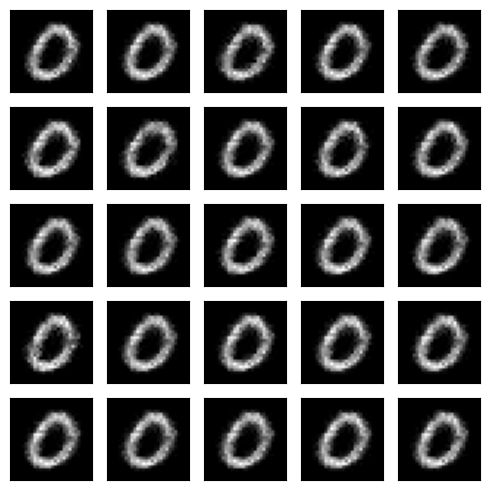

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))

for ax in axes.flatten():
    sample = model.sample(context=0.0).detach().squeeze(0)
    sample[sample < 0] = 0
    sample[sample > 1] = 1
    sample = (sample * 255).to(torch.int32)
    sample = (
        sample.reshape(4, 4, 7, 7) # sample.reshape(4, 4, 7, 7)  # Split spatial dims into (n, k) blocks
        .permute(2, 0, 3, 1)                # Reorder axes to (c, n, n, k, k)
        .reshape(28, 28)               # Combine channels and blocks into (k²c, n, n)
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(sample, cmap="grey")
plt.tight_layout()

plt.show()

In [6]:
from src.explib.datasets import MnistDequantized
mnist0 = MnistDequantized(dataloc="/home/faried/Projects/USFlows/data/mnist", space_to_depth_factor=4, digit=0)


In [7]:
calbration_set = mnist0[:1000][0]
latent_representations = model.backward(calbration_set)
logprobs = model.base_distribution.log_prob(latent_representations)
latent_norms = (latent_representations - model.base_distribution.loc).reshape(-1, 784).norm(p=1, dim=-1)
profiles = model.base_distribution.r_profile(latent_norms)

In [8]:
expected = model.base_distribution.norm_distribution.sample([10000])
expected_tail = expected[expected >= latent_norms.min()]

In [9]:
expected_tail.shape

torch.Size([0])

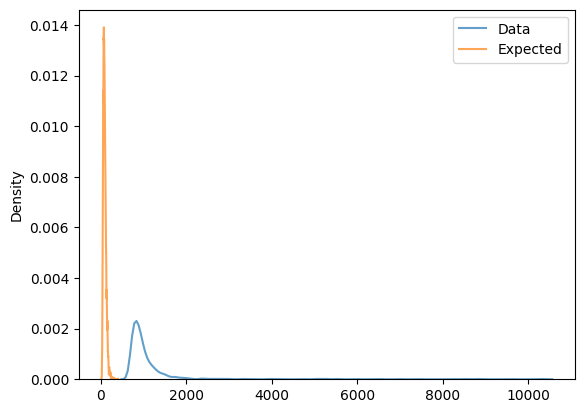

In [10]:
bw = .25
sns.kdeplot(latent_norms.detach(), bw_adjust=bw, alpha=0.7, label="Data")
sns.kdeplot(expected.detach().reshape(-1), bw_adjust=bw, alpha=0.7, label="Expected")
#sns.kdeplot(expected_tail.detach().reshape(-1), bw_adjust=bw, alpha=0.7, label="Expected Tail")
plt.legend()
plt.show()

In [27]:
i = 100
rs = latent_representations.reshape(latent_representations.shape[0], -1).norm(1, dim=-1).sort()[0].detach() #torch.linspace(10, 3000, 500)
ps = model.base_distribution.r_profile(rs).detach()
#plt.plot(rs, ps)
#plt.show()


event_dims = tuple(
    range(latent_representations.dim() - len(model.base_distribution.event_shape),
          latent_representations.dim()
         )
)
norm = (latent_representations - model.base_distribution.loc).norm(p=1, dim=event_dims)
#norm = latent_representations[0].flatten().norm(p=1)

print(model.base_distribution.log_prob(latent_representations[:100]))
print(model.base_distribution.r_profile(norm))
print(model.base_distribution.norm_distribution.log_prob(norm) - model.base_distribution.log_delta_volume(1, norm))


tensor([ 3.6459e+01, -7.5776e+01, -1.3246e+02, -3.3859e+01, -1.3449e+02,
        -3.5288e+02, -3.6463e+02, -5.3363e+02, -1.6644e+02,  1.1129e+01,
        -4.5846e+01, -6.5443e+01,  2.5461e+01, -5.1702e+02, -1.2541e+02,
         3.2425e+00,  6.6869e+00, -4.6837e+02, -1.0631e+01, -3.1263e+01,
        -9.6028e+01, -7.5852e+01, -1.2363e+02, -3.8187e+01, -1.5659e+02,
        -2.5160e+02, -1.1417e+02, -4.4112e+01, -5.6047e+02, -2.0034e+02,
        -1.6490e+02, -5.6390e+01, -3.9681e+01, -2.9980e+02,  3.9648e+01,
         2.1153e+01,  9.7726e+01,  7.1987e+01, -2.4632e+01, -1.5548e+00,
        -3.3623e+01,  1.0391e+01, -7.3203e+02, -2.0973e+03,  2.4965e+01,
        -1.2566e+02, -2.1839e+02, -7.8466e+02, -8.8377e+01, -1.7410e+02,
        -7.9494e+01, -2.6004e+01, -2.0673e+02, -5.9757e+02, -1.1206e+02,
        -7.6383e+00, -1.9667e+02, -3.6760e+02, -1.3070e+02,  9.2542e+01,
        -1.2980e+02,  7.1547e+01,  3.7817e+01,  4.7418e+01, -6.9639e+01,
        -2.0638e+02, -1.4730e+02,  2.2161e+01, -5.2

In [12]:
norms_reshape = (latent_representations - model.base_distribution.loc).reshape(-1, 784).norm(p=1, dim=-1)
event_dims = tuple(
    range(latent_representations.dim() - len(model.base_distribution.event_shape),
          latent_representations.dim()
         )
)
norms_event = (latent_representations - model.base_distribution.loc).norm(p=1, dim=event_dims)
norms_event 

tensor([  72.1478,   83.2674,   89.5192,   78.9270,   89.7512,  118.6238,
         120.4174,  149.4253,   93.4896,   74.5199,   80.1446,   82.1757,
          73.1684,  146.2891,   88.7169,   75.2743,   74.9439,  137.4772,
          76.6199,   78.6657,   85.4492,   83.2754,   88.5153,   79.3644,
          92.3205,  104.2313,   87.4523,   79.9673,  154.6376,   97.6262,
          93.3055,   81.2312,   79.5160,  110.8487,   71.8545,   73.5721,
          66.7177,   68.9474,   78.0023,   75.7370,   78.9032,   74.5902,
         192.5165, 1100.8661,   73.2147,   88.7445,   99.9019,  205.9033,
          84.6182,   94.4084,   83.6637,   78.1391,   98.4256,  162.1396,
          87.2163,   76.3277,   97.1700,  120.8750,   89.3177,   67.1609,
          89.2158,   68.9861,   72.0228,   71.1451,   82.6173,   98.3822,
          91.2317,   73.4773,   80.8572,   82.6433,   82.9154,  117.3899,
          84.0294,  106.6756,  136.3762,   77.5079,  115.4267,   77.6317,
          78.9581,   72.7156,  142.403

In [13]:
calbration_set = mnist0[:1000][0]
model.calibrated_latent_radial_udl_profile(0.5, calbration_set)

logprob 340.8048095703125


tensor([[1.0000e-20, 6.3006e+01]])

In [33]:
model.base_distribution.norm_distribution.log_prob(norm.unsqueeze(-1)).shape

torch.Size([1000])

In [29]:
norm

tensor([  72.1478,   83.2674,   89.5192,   78.9270,   89.7512,  118.6238,
         120.4174,  149.4253,   93.4896,   74.5199,   80.1446,   82.1757,
          73.1684,  146.2891,   88.7169,   75.2743,   74.9439,  137.4772,
          76.6199,   78.6657,   85.4492,   83.2754,   88.5153,   79.3644,
          92.3205,  104.2313,   87.4523,   79.9673,  154.6376,   97.6262,
          93.3055,   81.2312,   79.5160,  110.8487,   71.8545,   73.5721,
          66.7177,   68.9474,   78.0023,   75.7370,   78.9032,   74.5902,
         192.5165, 1100.8661,   73.2147,   88.7445,   99.9019,  205.9033,
          84.6182,   94.4084,   83.6637,   78.1391,   98.4256,  162.1396,
          87.2163,   76.3277,   97.1700,  120.8750,   89.3177,   67.1609,
          89.2158,   68.9861,   72.0228,   71.1451,   82.6173,   98.3822,
          91.2317,   73.4773,   80.8572,   82.6433,   82.9154,  117.3899,
          84.0294,  106.6756,  136.3762,   77.5079,  115.4267,   77.6317,
          78.9581,   72.7156,  142.403

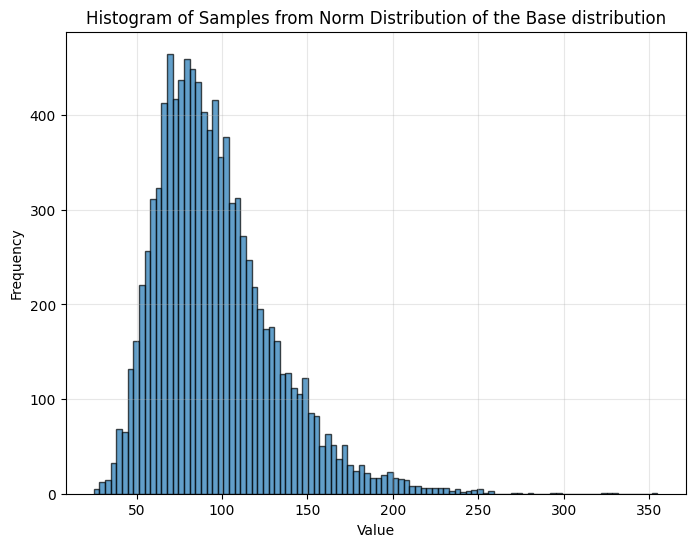

In [40]:
samples = mnist0[:1000]

if isinstance(samples, torch.Tensor):
    samples = samples.detach().numpy()

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of Samples from Norm Distribution of the Base distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
         

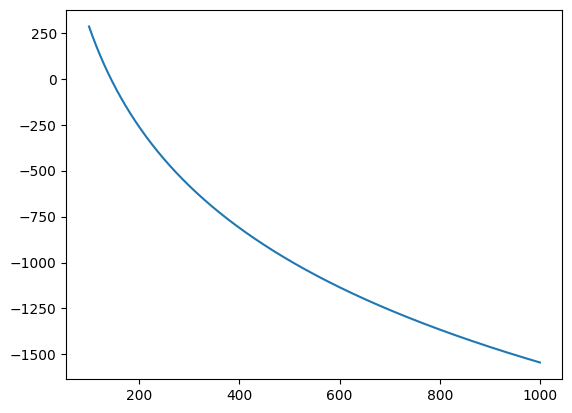

In [9]:
samples = torch.linspace(100, 1000, 1000)
profiles = model.base_distribution.r_profile(samples)
plt.plot(samples.detach(), profiles.detach())

In [10]:
model.base_distribution.radial_udl_profile(threshold=-100)

tensor([[1.0000e-20, 1.6002e+02]])

In [55]:
n_samples = 10000
q = .1

samples = torch.stack([d.sample() for _ in range(n_samples)])
logproborg = d.log_prob(samples)
r = samples.reshape(-1, 784).norm(dim=-1, p=1)

logprob, indices = torch.sort(logproborg)
threshold_idx = int(n_samples * (1-q))
threshold = logprob[threshold_idx]

indices = torch.arange(n_samples)
r, ridxs = torch.sort(r)
indices = indices[logproborg[ridxs] > threshold]

def merge_intervals(intervals: torch.Tensor) -> torch.Tensor:
    """returns start and end of consecutive intervals of indices"""
    if len(intervals) == 1:
        return torch.tensor([[intervals[0], intervals[0]]])

    intervals = intervals.sort().values
    merged = []
    start = intervals[0]
    end = intervals[0]
    for i in range(1, len(intervals)):
        if intervals[i] == end + 1:
            end = intervals[i]
        else:
            merged.append([start, end])
            start = intervals[i]
            end = intervals[i]
    merged.append([start, end])
    return torch.tensor(merged)

r[merge_intervals(indices)]


tensor([[167.1230, 172.3712],
        [172.4038, 174.0072],
        [174.0226, 174.2758],
        [174.2769, 174.3353],
        [174.3484, 174.3529],
        [174.3648, 174.3717],
        [174.4054, 174.5983],
        [174.6393, 174.9692],
        [174.9817, 175.1465],
        [175.1766, 175.2386],
        [175.2508, 175.2644],
        [175.2912, 175.4179],
        [175.4411, 175.4994],
        [175.5222, 175.5328],
        [175.5411, 175.6823],
        [175.7205, 175.7455],
        [175.7586, 175.7804],
        [175.7858, 175.8665],
        [175.8699, 175.8886],
        [175.9135, 175.9228],
        [175.9331, 175.9893],
        [176.0207, 176.1361],
        [176.1841, 176.1915],
        [176.2050, 176.2095],
        [176.2470, 176.2483],
        [176.2751, 176.2756],
        [176.3212, 176.3231],
        [176.3495, 176.4351],
        [176.4424, 176.4448],
        [176.4724, 176.4724],
        [176.4859, 176.5101],
        [176.5326, 176.5326],
        [176.5535, 176.6686],
        [1

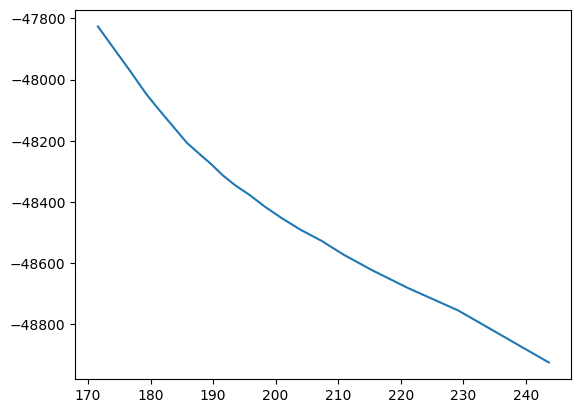

In [58]:
plt.plot(r.detach().reshape(-1, 500)[:, 49], logproborg[ridxs].detach().reshape(-1, 500).mean(dim=-1))

# RadialDistribution loc norms

In [64]:
d.norm_distribution.log_prob(10*torch.ones(1)) + d.log_delta_volume(1, 10*torch.ones(1))

tensor([-2114.0122], grad_fn=<AddBackward0>)

# Random loc distances

In [343]:
perm1 = np.random.choice(len(locs), 500, replace=True)
perm2 = np.random.choice(len(locs), 500, replace=True)
diffs = locs[perm1] - locs[perm2]
diffs.norm(dim=-1).max()

tensor(1.3728, grad_fn=<MaxBackward1>)

# Normdistribution (lognormal) loc

In [19]:
model.log_prob(model.sample())
model.base_distribution.



In [16]:
from src.usflows.distributions import RadialDistribution, LogNormal
dist = RadialDistribution(
            p = 1.0,
            loc = torch.zeros([16, 7, 7]),
            norm_distribution = LogNormal(
                loc = torch.ones([1]) * 4.5,
                scale = torch.ones([1]) * .35
            )
)

In [17]:
dist.batch_shape

torch.Size([])

# Mixture component probs

In [346]:
model.base_distribution.mixture_distribution.logits.softmax(-1)

tensor([0.0530, 0.0463, 0.0366, 0.0534, 0.0400, 0.0367, 0.0499, 0.0650, 0.0568,
        0.0529, 0.0645, 0.0380, 0.0555, 0.0431, 0.0572, 0.0597, 0.0388, 0.0501,
        0.0529, 0.0497], grad_fn=<SoftmaxBackward0>)

In [199]:
for p in model.base_distribution.parameters():
    print(p.shape)

torch.Size([20, 16, 7, 7])
torch.Size([20, 1, 1, 1])
torch.Size([20, 1, 1, 1])
torch.Size([20])
torch.Size([20])


In [42]:
model.base_distribution.radial_batch.norm_distribution._scale_unconstrained

Parameter containing:
tensor([[[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]],


        [[[-0.3206]]]], requires_grad=True)

In [705]:
model.simplify().to_onnx("model0_1404_forward.onnx", export_mode="forward")
model.simplify().to_onnx("model0_1404_backward.onnx", export_mode="backward")
model.simplify().to_onnx("model0_1404_log_prob.onnx", export_mode="log_prob")
#model.simplify().to_onnx("model0_1404_sample.onnx", export_mode="sample")

/Users/fariedabuzaid/Projects/veriflow/src/veriflow/distributions.py:391: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  dims = tuple(
/Users/fariedabuzaid/Projects/veriflow/src/veriflow/distributions.py:391: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  dims = tuple(


In [8]:
sample = model.base_distribution.sample()
loss = model.base_distribution.log_prob(sample)
loss.backward()


In [4]:
for p in model.base_distribution.parameters():
    print(p.grad)

None
None
None
None
None


In [19]:
for p in model.base_distribution.parameters():
    print(p)

Parameter containing:
tensor([[[[ 1.0031e-02,  1.0164e-02, -1.6387e-02,  ...,  1.9716e-03,
            1.7719e-02, -2.5531e-04],
          [-1.8913e-03,  1.0295e-02, -6.4433e-03,  ..., -1.4014e-02,
           -2.3927e-04,  1.0101e-02],
          [-2.3292e-03,  2.3896e-03,  2.1894e-03,  ..., -1.1618e-02,
            2.0540e-03,  2.6155e-02],
          ...,
          [-1.6701e-02, -6.0760e-03, -2.8341e-03,  ..., -1.5256e-02,
           -4.4774e-03,  2.9611e-03],
          [-1.4698e-04,  6.7640e-03, -2.2434e-02,  ...,  1.2810e-02,
            6.1466e-03,  8.5384e-03],
          [ 5.3243e-03,  7.7741e-04,  5.4816e-03,  ..., -3.6055e-03,
            3.5744e-03,  1.2706e-02]],

         [[-1.6198e-02,  7.5895e-03,  3.6023e-03,  ..., -4.8117e-03,
           -1.4401e-02,  1.2110e-02],
          [-1.0911e-02, -1.4430e-02, -6.1218e-04,  ..., -4.0726e-03,
            4.5207e-04,  3.6635e-03],
          [-4.2392e-03,  2.7780e-03, -3.1214e-03,  ...,  9.7022e-05,
           -6.8406e-03, -1.4899e-02]

In [29]:
dist = Laplace(torch.zeros(2), torch.ones(2))

In [30]:
sample = dist.sample()

In [31]:
loss = dist.log_prob(sample)
loss.backward()

In [33]:
dist.trainable_args["scale"].grad

tensor([-0.4838,  0.1757])

In [21]:
from src.explib.datasets import MnistSplit

In [22]:
data = MnistSplit(digit=0)
data = data.get_train()

In [23]:
idx = torch.randint(high=len(data), size=(25,))
samples = data[idx][0]

In [160]:
for p in model.

Parameter containing:
tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0270,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3186,  0.0968,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3697, -0.1932,  0.2301,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3760,  0.2886,  0.1459, -0.4744,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5718,  0.0348,  0.3150,  0.0731, -0.4607,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],


In [482]:
idx

tensor([[1571, 4825, 4400, 2169, 3472],
        [2644, 1120, 4577, 2218, 1734],
        [  16, 4742, 5178, 1131, 2510],
        [4268, 2022, 2380, 2396, 4587],
        [ 475, 4833, 2494, 2439, 4606]])

In [63]:
model.log_prob(model.sample()).backward()

/Users/fariedabuzaid/Library/Caches/pypoetry/virtualenvs/veriflow-75zEOOJt-py3.12/lib/python3.12/site-packages/torch/distributions/distribution.py:307: UserWarning: <class 'torch.distributions.mixture_same_family.MixtureSameFamily'> does not define `support` to enable sample validation. Please initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [80]:
model.trainable_layers.parameters()

<generator object Module.parameters at 0x30d567760>

In [81]:
model.parameters()

<generator object Module.parameters at 0x307a073e0>

In [1]:
from src.veriflow.distributions import LMM

In [2]:
LMM(

    
)

TypeError: LMM() missing 1 required positional argument: 'DistributionModule'

In [71]:
model.base_distribution.other_args["component_distribution"].params["loc"]

Parameter containing:
tensor([[[[-4.5760e+00,  2.6095e-01,  2.4944e+00,  ...,  1.7868e+00,
           -4.2473e+00, -3.1167e-01],
          [-6.3537e+00, -2.0498e+00,  2.4322e+00,  ...,  1.2598e+01,
            6.1041e-01, -1.0609e+00],
          [-1.8890e+00,  1.3838e+00,  5.4301e+00,  ..., -9.7346e+00,
            2.4440e+00, -5.0277e+00],
          ...,
          [-7.6773e-02, -4.0527e+00, -3.0830e+00,  ...,  5.2256e+00,
            4.2926e+00, -2.5828e+00],
          [-1.0447e-01, -5.0151e+00,  4.4528e-01,  ..., -6.1837e+00,
           -4.4376e+00,  1.9833e+00],
          [ 7.7942e+00,  2.6597e+00,  2.0872e+00,  ..., -1.1892e+00,
            8.7347e+00, -2.4668e+00]],

         [[ 4.0066e+00, -7.5846e+00,  2.6076e+00,  ...,  7.3851e+00,
            9.0517e+00,  4.2172e+00],
          [-6.5916e+00,  4.7106e+00, -9.3009e+00,  ..., -8.6252e-02,
            4.3991e-01,  1.9344e+00],
          [ 5.1490e-01,  2.1399e-01,  8.7020e-01,  ..., -5.2603e-01,
            4.7218e+00,  1.6599e+00]

In [68]:
old_loc - new_loc

tensor([[[[-3.0231e-03,  2.6524e-03,  2.2802e-03,  ..., -1.9252e-04,
           -5.3167e-04,  1.2851e-04],
          [-1.5712e-03,  7.5340e-04,  4.4107e-04,  ...,  3.6144e-04,
           -1.0071e-03, -9.2638e-04],
          [-3.0088e-04, -1.0014e-03, -8.4925e-04,  ..., -2.7084e-04,
           -5.8651e-04, -4.2915e-04],
          ...,
          [-6.2261e-04, -9.0504e-04, -5.7292e-04,  ...,  1.4033e-03,
           -1.5531e-03,  1.1847e-03],
          [-9.6891e-04, -7.2479e-04,  1.4904e-03,  ..., -6.8760e-04,
            4.6968e-04,  1.0253e-03],
          [ 1.2498e-03, -1.3964e-03,  7.7915e-04,  ..., -5.1093e-04,
            1.5955e-03,  1.1015e-04]],

         [[ 2.1815e-03, -1.4424e-03,  5.5408e-04,  ..., -2.2078e-04,
           -1.8215e-03,  1.0538e-03],
          [ 4.7684e-04, -3.2282e-04,  8.8501e-04,  ..., -8.5220e-04,
           -2.3592e-04,  6.8343e-04],
          [-9.9796e-04, -5.5350e-04,  8.5860e-04,  ..., -5.7769e-04,
            2.5797e-04,  1.0926e-03],
          ...,
     

In [140]:
sample.round()


tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 1., 1., 0.],
         [0., 0., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 1., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 1., 0., 0.],
         [0., 0., 1., 0., 1., 0., 0.],
         [0., 1., 0

In [141]:
sample = (
    sample.reshape(4, 4, 7, 7)  # Split spatial dims into (n, k) blocks
    .permute(2, 0, 3, 1)                # Reorder axes to (c, n, n, k, k)
    .reshape(28, 28)               # Combine channels and blocks into (k²c, n, n)
)

In [143]:
sample.round()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
  

In [145]:
sample.reshape(16, 7, 7).round()


tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0

In [65]:

from src.veriflow.distributions import RadialMM, LogNormal

norm_dists = LogNormal(loc=torch.ones(2,1), scale=torch.ones(2,1), n_batch_dims=1)

In [66]:
sample = norm_dists.sample([2])
sample

tensor([[[12.8923],
         [ 3.9039]],

        [[ 8.7049],
         [ 2.8075]]])

In [67]:
rad = RadialMM(norm_distribution=norm_dists, loc=torch.zeros(2, 3), p=1.)

In [68]:
sample = rad.sample([2, 2])
sample

tensor([[[-0.0652,  0.1423,  1.1670],
         [ 0.0408, -9.3055, -6.6674]],

        [[ 1.1204,  1.0238, -1.0689],
         [ 0.0512,  0.7589, -0.2022]]])

In [69]:
rad.log_prob(sample)

tensor([[ -5.6541, -10.2364],
        [ -7.3525,  -4.7139]], grad_fn=<LogsumexpBackward0>)

In [56]:
rad.distribution._component_distribution.norm_distribution.sample([2])

tensor([[[0.3633],
         [5.1998]],

        [[0.5285],
         [0.0337]]])

In [124]:
class Tree(object):
    def __init__(self):
        self.root = None
        self.left_subtree = None
        self.right_subtree = None
    def insert(self, val: int):
        if self.root is not None:
            if self.root > val:
                if self.left_subtree is None:
                    self.left_subtree = Tree()
                    self.left_subtree.insert(val)
                else:
                    self.left_subtree.insert(val)
            elif self.root < val:
                if self.right_subtree is None:
                    self.right_subtree = Tree()
                    self.right_subtree.insert(val)
                else:
                    self.right_subtree.insert(val)
            else:
                pass
        else:
            self.root = val

    def _left_attach(self, subtree):
        if self.left_subtree is None:
            self.left_subtree = subtree
        else:
            self.left_subtree._left_attach(subtree)
    
    def delete(self, val):
        if self.root == val:
            if self.left_subtree is not None:
                self.root = self.left_subtree.root
                self.left_subtree = self.left_subtree.left_subtree
                if self.left_subtree.right_subtree is not None:
                    if self.right_subtree is None:
                        self.right_subtree = self.left_subtree.right_subtree
                else:
                    self.right_subtree._left_attach(self.left_subtree.right_subtree)
            elif self.right_subtree is not None:
                self.root = self.right_subtree.root
                self.right_subtree = self.right_subtree.right_subtree
                self.left_subtree = self.right_subtree.left_subtree
        else:
            self.root = None

    def sorted(self):
        result = []
        left = self.left_subtree.sorted() if self.left_subtree is not None else []
        right = self.right_subtree.sorted() if self.right_subtree is not None else []
        return left + [self.root] + right
          

In [128]:
import numpy as np
t = Tree()
for _ in range(10):
    val = np.random.randint(1000)
    t.insert(val)
    
t.sorted()

[7, 80, 360, 368, 409, 579, 796, 871, 899, 957]

In [30]:
from src.veriflow.distributions import RadialDistribution, RadialMM, LogNormal
d = RadialMM(
    loc=torch.randn(20, 16, 7, 7),
    p=2.0,
    norm_distribution=LogNormal(
        loc=torch.ones(20, 1, 1, 1),
        scale=torch.ones(20, 1, 1, 1) * .5,
        n_batch_dims=1
    ),
    mixture_weights=torch.ones(20)
)

In [31]:
sample = d.sample()
loss = d.log_prob(sample)
loss.backward()
for p in d.parameters():
    print(p.grad)

tensor([[[[-1.0641e-02, -1.8356e-02, -5.0627e-04,  ...,  4.2425e-03,
            5.4559e-03, -9.3546e-03],
          [ 2.3538e-03, -1.3041e-03,  4.5850e-03,  ..., -7.9635e-03,
           -8.3710e-03, -1.1148e-02],
          [ 5.7637e-03, -4.4658e-03,  1.9638e-02,  ...,  1.7102e-02,
            2.4164e-03,  1.8459e-02],
          ...,
          [ 6.0563e-03, -5.8210e-03, -2.5002e-02,  ..., -9.5405e-03,
            3.0469e-03,  1.3430e-02],
          [-3.5892e-03,  6.9478e-03,  2.5280e-03,  ...,  1.5228e-03,
           -1.1312e-02, -1.7733e-02],
          [ 6.9326e-03, -6.9347e-03, -1.0718e-02,  ..., -8.3332e-03,
            5.2878e-03, -1.0400e-02]],

         [[ 1.7683e-02,  1.1007e-02, -3.6408e-03,  ...,  5.3899e-03,
           -1.5014e-02,  1.1181e-02],
          [-1.3040e-02, -1.0310e-02, -4.1092e-03,  ...,  7.2969e-03,
           -1.1808e-03, -1.2547e-02],
          [ 6.9091e-03, -8.1012e-03,  5.9788e-03,  ..., -4.7404e-03,
           -1.5098e-02, -1.5397e-02],
          ...,
     

In [33]:
d = model.base_distribution

In [11]:
from copy import deepcopy
d = deepcopy(d)

In [34]:
d

RadialMM(
  (params): ParameterDict()
  (module_args): ModuleDict()
  (radial_batch): RadialDistribution(
    (norm_distribution): LogNormal(
      (params): ParameterDict()
      (module_args): ModuleDict()
    )
  )
  (mixture_distribution): Categorical(logits: torch.Size([20]))
)

In [43]:
from src.explib.config_parser import read_config, parse_raw_config, create_objects_from_classes

In [46]:
cfg_file = "/Users/fariedabuzaid/Projects/veriflow/experiments/mnist/mnist_usflow_cpu_gammamm.yaml"
cfg = read_config(cfg_file)

In [49]:
model_cls = cfg.experiments[0].trial_config['model_cfg']['type']
args = cfg.experiments[0].trial_config['model_cfg']['params']
args = create_objects_from_classes(args)
model = model_cls(**args)

In [48]:
cfg

In [50]:
basedist = model.base_distribution

In [51]:
sample = basedist.sample()
logprob = basedist.log_prob(sample)
logprob.backward()

In [52]:
basedist.radial_batch.loc.grad

tensor([[[[ 0.3666, -0.3666, -0.3666,  ..., -0.3666, -0.3666,  0.3666],
          [-0.3666, -0.3666,  0.3666,  ..., -0.3666, -0.3666, -0.3666],
          [-0.3666, -0.3666,  0.3666,  ...,  0.3666, -0.3666,  0.3666],
          ...,
          [ 0.3666, -0.3666,  0.3666,  ..., -0.3666,  0.3666, -0.3666],
          [ 0.3666, -0.3666, -0.3666,  ...,  0.3666,  0.3666,  0.3666],
          [ 0.3666, -0.3666,  0.3666,  ...,  0.3666,  0.3666,  0.3666]],

         [[ 0.3666, -0.3666, -0.3666,  ..., -0.3666, -0.3666, -0.3666],
          [ 0.3666,  0.3666,  0.3666,  ...,  0.3666,  0.3666, -0.3666],
          [ 0.3666, -0.3666, -0.3666,  ..., -0.3666,  0.3666, -0.3666],
          ...,
          [ 0.3666, -0.3666,  0.3666,  ..., -0.3666, -0.3666,  0.3666],
          [-0.3666, -0.3666,  0.3666,  ...,  0.3666,  0.3666,  0.3666],
          [ 0.3666, -0.3666, -0.3666,  ..., -0.3666,  0.3666,  0.3666]],

         [[ 0.3666, -0.3666, -0.3666,  ...,  0.3666, -0.3666,  0.3666],
          [ 0.3666, -0.3666,  

# Sample Model

In [2]:
cfg_file = "/Users/fariedabuzaid/Projects/veriflow/experiments/mnist/mnist_usflow_cpu_gammamm.yaml"
cfg = read_config(cfg_file)

In [3]:
model_cls = cfg.experiments[0].trial_config['model_cfg']['type']
args = cfg.experiments[0].trial_config['model_cfg']['params']
model = model_cls(**args)

In [19]:
basedist = model.base_distribution

In [53]:
sample = model.sample([300])
logprob = model.log_prob(sample).sum()
logprob.backward()

In [54]:
basedist.radial_batch.norm_distribution._scale_unconstrained.grad

tensor([[[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]],


        [[[75882712.]]]])

In [55]:
basedist.radial_batch.loc.grad

tensor([[[[-1.5038e+03, -2.7623e+04, -2.8114e+04,  ..., -2.4487e+04,
           -6.9384e+03,  1.4928e+04],
          [ 9.7563e+03,  1.2486e+03,  1.2930e+04,  ...,  1.9263e+04,
           -1.2752e+04, -1.8464e+04],
          [-2.0650e+04, -2.8314e+04,  9.6525e+03,  ...,  2.0308e+04,
           -3.2108e+04,  3.0122e+04],
          ...,
          [-2.1429e+04, -2.9542e+04,  8.2371e+03,  ...,  4.5072e+03,
            3.1373e+04, -9.9648e+03],
          [ 3.1175e+04, -1.7441e+04, -2.3124e+04,  ...,  2.3418e+04,
           -2.2743e+02,  8.2157e+03],
          [ 2.9476e+04,  2.3060e+04,  1.2316e+04,  ...,  3.2596e+04,
            1.8209e+04,  1.1998e+04]],

         [[ 1.9174e+04, -2.0554e+04, -2.6981e+04,  ..., -3.0075e+04,
           -2.3521e+03, -1.6305e+04],
          [ 1.8938e+04, -8.9389e+03,  2.0130e+04,  ...,  3.3050e+04,
            2.4771e+04, -1.7465e+04],
          [-1.3903e+04, -2.0882e+04,  1.1594e+04,  ...,  2.0876e+04,
            3.8507e+03, -3.1022e+04],
          ...,
     

In [19]:
logprob

tensor([4857.0884], grad_fn=<AddBackward0>)

In [12]:
sample.shape

torch.Size([1, 16, 7, 7])

In [23]:
args

{'soft_training': False,
 'training_noise_prior': Uniform(low: 9.999999682655225e-21, high: 0.009999999776482582),
 'prior_scale': 5.0,
 'coupling_blocks': 1,
 'lu_transform': 1,
 'householder': 0,
 'conditioner_cls': src.veriflow.networks.ConvNet2D,
 'conditioner_args': {'c_in': 16,
  'c_hidden': 32,
  'num_layers': 1,
  'padding': 1,
  'dilation': 1,
  'stride': 1,
  'kernel_size': 3,
  'rescale_hidden': 1,
  'normalize_layers': False,
  'gating': False},
 'in_dims': [16, 7, 7],
 'affine_conjugation': True,
 'nonlinearity': <ray.tune.search.sample.Categorical at 0x3125ba480>,
 'base_distribution': RadialMM(
   (radial_batch): RadialDistribution(
     (norm_distribution): LogNormal()
   )
   (mixture_distribution): Categorical()
   (_mixture_distribution): Categorical()
   (_component_distribution): RadialDistribution(
     (norm_distribution): LogNormal()
   )
 )}

In [3]:
cfg.experiments[0].conduct('.')

2025-04-28 18:10:16,950	INFO worker.py:1841 -- Started a local Ray instance.
/Users/fariedabuzaid/Library/Caches/pypoetry/virtualenvs/veriflow-75zEOOJt-py3.12/lib/python3.12/site-packages/ray/tune/impl/tuner_internal.py:125: RayDeprecationWarning: The `RunConfig` class should be imported from `ray.tune` when passing it to the Tuner. Please update your imports. See this issue for more context and migration options: https://github.com/ray-project/ray/issues/49454. Disable these warnings by setting the environment variable: RAY_TRAIN_ENABLE_V2_MIGRATION_WARNINGS=0
  _log_deprecation_warning(


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001

In [5]:
from copy import deepcopy
deepcopy(cfg.experiments[0].trial_config)

RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001

In [20]:
from src.explib.hyperopt import HyperoptExperiment

HyperoptExperiment._trial(cfg.experiments[0].trial_config)

/Users/fariedabuzaid/Projects/veriflow/src/explib/datasets.py:356: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  torch.Tensor(dataset),
/Users/fariedabuzaid/Projects/veriflow/src/veriflow/flows.py:88: SyntaxWarning: invalid escape sequence '\l'
  """Returns the log prior of the model parameters. The model is trained in maximum posterior fashion, i.e.
/Users/fariedabuzaid/Projects/veriflow/src/veriflow/flows.py:436: SyntaxWarning: invalid escape sequence '\l'
  """Returns the log prior of the model parameters. The model is trained in maximum posterior fashion, i.e.
/Users/fariedabuza

TypeError: 'Categorical' object cannot be interpreted as an integer

In [21]:
cfg.experiments[0].trial_config

{'epochs': 100000,
 'patience': 20,
 'logging': {'images': False, 'image_shape': [28, 28]},
 'dataset': {'type': src.explib.datasets.MnistSplit,
  'params': {'dataloc': '/Users/fariedabuzaid/Projects/veriflow/data',
   'space_to_depth_factor': 4,
   'device': 'cpu'}},
 'batch_size': <ray.tune.search.sample.Categorical at 0x157d52300>,
 'optim_cfg': {'optimizer': torch.optim.adam.Adam,
  'params': {'lr': 0.0001, 'weight_decay': 0.0}},
 'model_cfg': {'type': src.veriflow.flows.USFlow,
  'params': {'soft_training': False,
   'training_noise_prior': Uniform(low: 9.999999682655225e-21, high: 0.009999999776482582),
   'prior_scale': 5.0,
   'coupling_blocks': 1,
   'lu_transform': 1,
   'householder': 0,
   'conditioner_cls': src.veriflow.networks.ConvNet2D,
   'conditioner_args': {'c_in': 16,
    'c_hidden': 32,
    'num_layers': 1,
    'padding': 1,
    'dilation': 1,
    'stride': 1,
    'kernel_size': 3,
    'rescale_hidden': 1,
    'normalize_layers': False,
    'gating': False},
   'in